In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import numpy as np
import os
import cv2
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt

In [ ]:
# Paths for preprocessed data
PREPROCESSED_TRAIN_DIR = "../input/preprocessed-data/traffic/trainNew"
PREPROCESSED_TEST_DIR = "../input/preprocessed-data/traffic/testNew"

image_size = (100, 100)

# Load preprocessed training data
print("Loading preprocessed training data...")
X_train = []
Y_train = []

for class_name in os.listdir(PREPROCESSED_TRAIN_DIR):
    class_dir = os.path.join(PREPROCESSED_TRAIN_DIR, class_name)
    label = int(class_name)  # As directories are named by class numbers
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Images are already grayscale due to preprocessing
        if img is not None:
            X_train.append(img)
            Y_train.append(label)

X_train = np.array(X_train).reshape(-1, *image_size, 1)
Y_train = np.array(Y_train)
print(f"Loaded {X_train.shape[0]} training images.")

Loading preprocessed training data...
Loaded 6000 training images.


In [ ]:
# Load preprocessed test data
print("Loading preprocessed test data...")
X_test = []
Y_test = []

for img_name in os.listdir(PREPROCESSED_TEST_DIR):
    img_path = os.path.join(PREPROCESSED_TEST_DIR, img_name)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  
    if img is not None:
        X_test.append(img)
        
        label = int(img_name.split('_')[1])  # Extract digits after 'preprocessed_' for class label
        Y_test.append(label)

X_test = np.array(X_test).reshape(-1, *image_size, 1)
Y_test = np.array(Y_test)
print(f"Loaded {X_test.shape[0]} test images.")

Loading preprocessed test data...
Loaded 1896 test images.


In [ ]:
num_classes = len(np.unique(Y_train))  # Determine classes from Y_train
print(f"Number of classes: {num_classes}")

# Check if labels need to be normalized to the range [0, num_classes - 1]
if Y_train.min() < 0 or Y_train.max() >= num_classes:
    print("Adjusting labels to be in the range [0, num_classes - 1]...")
    label_mapping = {label: idx for idx, label in enumerate(sorted(np.unique(Y_train)))}
    Y_train = np.array([label_mapping[label] for label in Y_train])  # Map Y_train
    Y_test = np.array([label_mapping[label] for label in Y_test])    # Map Y_test

# Categorically encode the labels
Y_train_encoded = to_categorical(Y_train, num_classes=num_classes)
Y_test_encoded = to_categorical(Y_test, num_classes=num_classes)

# Verify shapes
print(f"Y_train shape after categorical encoding: {Y_train_encoded.shape}")
print(f"Y_test shape after categorical encoding: {Y_test_encoded.shape}")

Number of classes: 40
Adjusting labels to be in the range [0, num_classes - 1]...
Y_train shape after categorical encoding: (6000, 40)
Y_test shape after categorical encoding: (1896, 40)


In [5]:
print("Unique labels in Y_train:", np.unique(Y_train))
print("Unique labels in Y_test:", np.unique(Y_test))
Y_train

Unique labels in Y_train: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
Unique labels in Y_test: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]


array([ 7,  7,  7, ..., 16, 16, 16])

In [ ]:
# Flatten data for the MLP
X_train_flattened = X_train.reshape(X_train.shape[0], -1)
X_test_flattened = X_test.reshape(X_test.shape[0], -1)

Y_train_flattened = Y_train_encoded.reshape(Y_train.shape[0], -1)  # Flatten to (samples, num_classes)
Y_test_flattened = Y_test_encoded.reshape(Y_test.shape[0], -1)

print("X_train_flattened shape:", X_train_flattened.shape)  # (samples, features)
print("Y_train shape:", Y_train_flattened.shape)  # (samples, num_classes)
print("X_test_flattened shape:", X_test_flattened.shape) 
print("Y_test shape:", Y_test_flattened.shape) 

# Normalize data
X_train_flattened = X_train_flattened / 255.0
X_test_flattened = X_test_flattened / 255.0

# Function to build MLP model
def build_mlp(input_size, num_classes, layers, units, dropout_rate):
    model = Sequential()
    for i in range(layers):
        if i == 0:
            model.add(Dense(units, activation='relu', input_shape=(input_size,)))
        else:
            model.add(Dense(units, activation='relu'))
        model.add(Dropout(dropout_rate))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Define multiple architectures
mlp_architectures = [
    {'layers': 2, 'units': 512, 'dropout_rate': 0.5},
    {'layers': 3, 'units': 512, 'dropout_rate': 0.4},
    {'layers': 4, 'units': 512, 'dropout_rate': 0.4},
]

X_train_flattened shape: (6000, 10000)
Y_train shape: (6000, 40)
X_test_flattened shape: (1896, 10000)
Y_test shape: (1896, 40)


In [ ]:
def evaluate_mlp_with_cv(X, Y, input_size, num_classes, architecture, num_folds=10):
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
    fold_metrics = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        print(f"Fold {fold + 1}/{num_folds}...")
        
        # Split data into training and validation sets
        X_train_fold, X_val_fold = X[train_idx], X[val_idx]
        Y_train_fold, Y_val_fold = Y[train_idx], Y[val_idx]

        # Build and train the model
        model = build_mlp(
            input_size=input_size,
            num_classes=num_classes,
            **architecture
        )
        model.fit(
            X_train_fold, Y_train_fold,
            epochs=50,
            batch_size=32,
            verbose=1
        )

        # Predict on validation data
        Y_val_pred_probs = model.predict(X_val_fold)
        Y_val_pred = np.argmax(Y_val_pred_probs, axis=1)
        Y_val_true = np.argmax(Y_val_fold, axis=1)

        # Performance metrics
        accuracy = accuracy_score(Y_val_true, Y_val_pred)
        precision = precision_score(Y_val_true, Y_val_pred, average='weighted', zero_division=0)
        recall = recall_score(Y_val_true, Y_val_pred, average='weighted', zero_division=0)
        f1 = f1_score(Y_val_true, Y_val_pred, average='weighted', zero_division=0)

        # Appending metrics for this fold
        fold_metrics.append({
            'fold': fold + 1,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
        })

    return fold_metrics

In [ ]:
# Evaluate all architectures using 10-fold cross-validation
cv_results = []

for i, arch in enumerate(mlp_architectures):
    print(f"\nEvaluating Architecture {i + 1}/{len(mlp_architectures)}: {arch}")

    # Perform 10-fold cross-validation
    fold_metrics = evaluate_mlp_with_cv(
        X=X_train_flattened,
        Y=Y_train_flattened,
        input_size=X_train_flattened.shape[1],
        num_classes=num_classes,
        architecture=arch,
        num_folds=10
    )
    
    # Average metrics across all folds
    avg_metrics = {
        'accuracy': np.mean([m['accuracy'] for m in fold_metrics]),
        'precision': np.mean([m['precision'] for m in fold_metrics]),
        'recall': np.mean([m['recall'] for m in fold_metrics]),
        'f1_score': np.mean([m['f1_score'] for m in fold_metrics]),
    }
    
    # Add architecture and metrics to the results
    cv_results.append({
        'architecture': arch,
        **avg_metrics
    })

print("\nCross-Validation Performance Metrics for All Architectures:")
for i, result in enumerate(cv_results):
    print(f"Model {i + 1} - Architecture: {result['architecture']}")
    print(f"  Accuracy (CV): {result['accuracy']:.4f}")
    print(f"  Precision (CV): {result['precision']:.4f}")
    print(f"  Recall (CV): {result['recall']:.4f}")
    print(f"  F1 Score (CV): {result['f1_score']:.4f}")


Evaluating Architecture 1/3: {'layers': 2, 'units': 512, 'dropout_rate': 0.5}
Fold 1/10...


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


I0000 00:00:1732852925.460939      67 service.cc:145] XLA service 0x7dbbfc006cc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732852925.460996      67 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 68/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0276 - loss: 4.0124

I0000 00:00:1732852928.700405      67 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


169/169 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.0338 - loss: 3.8762
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0367 - loss: 3.6578
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0565 - loss: 3.5962
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0664 - loss: 3.5003
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0684 - loss: 3.4262
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0774 - loss: 3.3797
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0749 - loss: 3.3372
Epoch 8/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0805 - loss: 3.3141
Epoch 9/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0868 - loss: 3.2767
Epoch 10/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0835 - loss: 3.2445
Epoch 11/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1000 - loss: 3.2254
Epoch 12/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accurac

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.0302 - loss: 3.8782
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0340 - loss: 3.6697
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0377 - loss: 3.6383
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0634 - loss: 3.5481
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0692 - loss: 3.4810
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0775 - loss: 3.4115
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0788 - loss: 3.3419
Epoch 8/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0992 - loss: 3.2779
Epoch 9/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1043 - loss: 3.2401
Epoch 10/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1060 - loss: 3.2457
Epoch 11/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1073 - loss: 3.2205
Epoch 12/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/ste

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.0322 - loss: 3.8485
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0425 - loss: 3.6553
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0478 - loss: 3.6076
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0601 - loss: 3.5287
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0697 - loss: 3.4454
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0751 - loss: 3.3957
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0901 - loss: 3.3520
Epoch 8/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0910 - loss: 3.3189
Epoch 9/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0911 - loss: 3.3164
Epoch 10/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1022 - loss: 3.2438
Epoch 11/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1103 - loss: 3.2043
Epoch 12/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/ste

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.0270 - loss: 3.8532
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0372 - loss: 3.6649
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0403 - loss: 3.6389
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0574 - loss: 3.5630
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0678 - loss: 3.4761
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0663 - loss: 3.4481
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0800 - loss: 3.3775
Epoch 8/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0830 - loss: 3.3287
Epoch 9/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0850 - loss: 3.3159
Epoch 10/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1002 - loss: 3.2485
Epoch 11/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0895 - loss: 3.2468
Epoch 12/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/ste

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.0290 - loss: 3.8742
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0486 - loss: 3.6352
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0729 - loss: 3.5323
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0977 - loss: 3.4017
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1286 - loss: 3.2885
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1337 - loss: 3.2066
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1413 - loss: 3.1480
Epoch 8/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1666 - loss: 3.0637
Epoch 9/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1775 - loss: 2.9940
Epoch 10/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1773 - loss: 2.9493
Epoch 11/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1945 - loss: 2.8732
Epoch 12/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/ste

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.0267 - loss: 3.8615
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0411 - loss: 3.6556
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0516 - loss: 3.5912
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0515 - loss: 3.5283
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0573 - loss: 3.4836
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0676 - loss: 3.4364
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0678 - loss: 3.4060
Epoch 8/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0803 - loss: 3.3625
Epoch 9/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0885 - loss: 3.3331
Epoch 10/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0823 - loss: 3.3110
Epoch 11/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0963 - loss: 3.2636
Epoch 12/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/ste

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.0292 - loss: 3.8728
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0356 - loss: 3.6632
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0422 - loss: 3.6164
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0668 - loss: 3.5130
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0808 - loss: 3.4320
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0925 - loss: 3.3602
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0944 - loss: 3.2957
Epoch 8/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1135 - loss: 3.2119
Epoch 9/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1175 - loss: 3.1996
Epoch 10/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1259 - loss: 3.1366
Epoch 11/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1301 - loss: 3.1334
Epoch 12/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/ste

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.0318 - loss: 3.8719
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0419 - loss: 3.6556
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0620 - loss: 3.5724
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0832 - loss: 3.4674
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0947 - loss: 3.3829
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1081 - loss: 3.3111
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1260 - loss: 3.2113
Epoch 8/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1376 - loss: 3.1622
Epoch 9/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1490 - loss: 3.1057
Epoch 10/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1583 - loss: 3.0501
Epoch 11/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1731 - loss: 2.9929
Epoch 12/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/ste

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.0284 - loss: 3.8666
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0343 - loss: 3.6588
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0506 - loss: 3.5932
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0675 - loss: 3.5054
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0782 - loss: 3.4175
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0865 - loss: 3.3494
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0897 - loss: 3.3017
Epoch 8/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0954 - loss: 3.2315
Epoch 9/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1031 - loss: 3.2081
Epoch 10/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1113 - loss: 3.1396
Epoch 11/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1207 - loss: 3.1158
Epoch 12/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/ste

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.0267 - loss: 3.8857
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0411 - loss: 3.6631
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0488 - loss: 3.5960
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0532 - loss: 3.5080
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0726 - loss: 3.4300
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0772 - loss: 3.3753
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0847 - loss: 3.3300
Epoch 8/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0922 - loss: 3.3012
Epoch 9/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1056 - loss: 3.2442
Epoch 10/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1013 - loss: 3.2256
Epoch 11/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1046 - loss: 3.2049
Epoch 12/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/ste

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.0256 - loss: 3.8520
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0350 - loss: 3.6755
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0485 - loss: 3.5998
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0708 - loss: 3.4648
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0921 - loss: 3.3518
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0912 - loss: 3.2841
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1163 - loss: 3.1748
Epoch 8/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1323 - loss: 3.0933
Epoch 9/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1391 - loss: 3.0719
Epoch 10/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1563 - loss: 2.9848
Epoch 11/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1647 - loss: 2.9504
Epoch 12/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/ste

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.0291 - loss: 3.8218
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0333 - loss: 3.6666
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0529 - loss: 3.5516
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0652 - loss: 3.4325
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0776 - loss: 3.3652
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0969 - loss: 3.2889
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1020 - loss: 3.2473
Epoch 8/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1118 - loss: 3.2333
Epoch 9/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1216 - loss: 3.1398
Epoch 10/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1267 - loss: 3.1107
Epoch 11/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1261 - loss: 3.1018
Epoch 12/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/ste

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.0262 - loss: 3.8169
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0356 - loss: 3.6771
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0436 - loss: 3.6215
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0734 - loss: 3.5027
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0895 - loss: 3.3913
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1164 - loss: 3.2543
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1176 - loss: 3.1724
Epoch 8/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1308 - loss: 3.0938
Epoch 9/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1440 - loss: 3.0672
Epoch 10/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1493 - loss: 3.0048
Epoch 11/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1476 - loss: 2.9944
Epoch 12/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/ste

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.0283 - loss: 3.8280
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0364 - loss: 3.6726
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0446 - loss: 3.6205
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0654 - loss: 3.5054
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0668 - loss: 3.4242
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0737 - loss: 3.3736
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0796 - loss: 3.3018
Epoch 8/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0956 - loss: 3.2577
Epoch 9/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0989 - loss: 3.2261
Epoch 10/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1011 - loss: 3.2093
Epoch 11/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1086 - loss: 3.1468
Epoch 12/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/ste

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.0323 - loss: 3.8365
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0331 - loss: 3.6663
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0480 - loss: 3.5867
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0704 - loss: 3.4361
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0889 - loss: 3.3237
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0897 - loss: 3.2537
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1079 - loss: 3.2021
Epoch 8/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1200 - loss: 3.1121
Epoch 9/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1278 - loss: 3.0816
Epoch 10/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1372 - loss: 3.0319
Epoch 11/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1541 - loss: 2.9632
Epoch 12/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/ste

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.0273 - loss: 3.8384
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0338 - loss: 3.6798
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0432 - loss: 3.6140
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0524 - loss: 3.5292
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0666 - loss: 3.4226
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0729 - loss: 3.3620
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0877 - loss: 3.3019
Epoch 8/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0857 - loss: 3.2635
Epoch 9/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0999 - loss: 3.2231
Epoch 10/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0996 - loss: 3.1943
Epoch 11/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1139 - loss: 3.1644
Epoch 12/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/ste

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.0311 - loss: 3.8413
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0480 - loss: 3.6605
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0635 - loss: 3.5673
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0740 - loss: 3.4480
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0981 - loss: 3.3223
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0895 - loss: 3.2665
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1178 - loss: 3.1673
Epoch 8/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1267 - loss: 3.1212
Epoch 9/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1340 - loss: 3.0603
Epoch 10/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1573 - loss: 3.0183
Epoch 11/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1511 - loss: 2.9721
Epoch 12/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/ste

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.0239 - loss: 3.8477
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0331 - loss: 3.6809
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0337 - loss: 3.6433
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0428 - loss: 3.5656
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0588 - loss: 3.4827
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0622 - loss: 3.4212
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0685 - loss: 3.3927
Epoch 8/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0786 - loss: 3.3462
Epoch 9/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0868 - loss: 3.3206
Epoch 10/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0840 - loss: 3.2658
Epoch 11/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0894 - loss: 3.2799
Epoch 12/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/ste

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.0318 - loss: 3.8225
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0355 - loss: 3.6764
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0415 - loss: 3.6343
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0585 - loss: 3.5003
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0730 - loss: 3.4096
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0854 - loss: 3.3081
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0907 - loss: 3.2499
Epoch 8/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1004 - loss: 3.2128
Epoch 9/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1023 - loss: 3.1975
Epoch 10/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1147 - loss: 3.1436
Epoch 11/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1220 - loss: 3.1158
Epoch 12/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/ste

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.0248 - loss: 3.8435
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0369 - loss: 3.6603
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0444 - loss: 3.6094
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0558 - loss: 3.5181
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0750 - loss: 3.4073
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0827 - loss: 3.3375
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1031 - loss: 3.2576
Epoch 8/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1204 - loss: 3.1619
Epoch 9/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1276 - loss: 3.1172
Epoch 10/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1426 - loss: 3.0375
Epoch 11/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1517 - loss: 3.0034
Epoch 12/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/ste

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - accuracy: 0.0276 - loss: 3.8389
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0224 - loss: 3.6866
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0305 - loss: 3.6603
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0350 - loss: 3.6394
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0365 - loss: 3.6216
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0371 - loss: 3.6125
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0373 - loss: 3.6076
Epoch 8/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0318 - loss: 3.5985
Epoch 9/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0366 - loss: 3.5906
Epoch 10/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0325 - loss: 3.5918
Epoch 11/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0363 - loss: 3.5928
Epoch 12/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/st

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - accuracy: 0.0240 - loss: 3.8311
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0239 - loss: 3.6869
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0283 - loss: 3.6818
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0356 - loss: 3.6412
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0445 - loss: 3.5585
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0467 - loss: 3.4999
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0484 - loss: 3.5050
Epoch 8/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0456 - loss: 3.5015
Epoch 9/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0549 - loss: 3.4797
Epoch 10/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0527 - loss: 3.4757
Epoch 11/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0525 - loss: 3.4641
Epoch 12/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/st

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - accuracy: 0.0254 - loss: 3.8274
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0236 - loss: 3.6892
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0354 - loss: 3.6681
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0418 - loss: 3.6297
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0503 - loss: 3.5535
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0673 - loss: 3.4917
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0761 - loss: 3.4212
Epoch 8/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0857 - loss: 3.3563
Epoch 9/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0891 - loss: 3.3184
Epoch 10/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0973 - loss: 3.2801
Epoch 11/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1045 - loss: 3.2408
Epoch 12/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/st

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - accuracy: 0.0289 - loss: 3.8276
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0329 - loss: 3.6887
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0376 - loss: 3.6584
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0331 - loss: 3.6152
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0407 - loss: 3.6040
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0378 - loss: 3.5772
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0357 - loss: 3.5770
Epoch 8/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0417 - loss: 3.5482
Epoch 9/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0477 - loss: 3.5505
Epoch 10/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0479 - loss: 3.5432
Epoch 11/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0506 - loss: 3.5269
Epoch 12/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/st

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - accuracy: 0.0230 - loss: 3.8372
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0287 - loss: 3.6913
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0303 - loss: 3.6814
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0375 - loss: 3.6386
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0435 - loss: 3.6090
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0410 - loss: 3.5823
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0495 - loss: 3.5565
Epoch 8/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0552 - loss: 3.5338
Epoch 9/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0425 - loss: 3.5408
Epoch 10/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0464 - loss: 3.5351
Epoch 11/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0515 - loss: 3.5229
Epoch 12/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/st

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - accuracy: 0.0247 - loss: 3.8232
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0301 - loss: 3.6886
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0285 - loss: 3.6809
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0338 - loss: 3.6467
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0502 - loss: 3.5744
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0436 - loss: 3.5086
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0464 - loss: 3.4830
Epoch 8/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0542 - loss: 3.4423
Epoch 9/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0552 - loss: 3.4059
Epoch 10/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0608 - loss: 3.3892
Epoch 11/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0595 - loss: 3.3688
Epoch 12/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/st

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - accuracy: 0.0295 - loss: 3.8221
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0334 - loss: 3.6855
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0365 - loss: 3.6490
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0454 - loss: 3.5781
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0394 - loss: 3.5435
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0446 - loss: 3.5198
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0516 - loss: 3.4944
Epoch 8/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0521 - loss: 3.4655
Epoch 9/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0598 - loss: 3.4578
Epoch 10/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0582 - loss: 3.4586
Epoch 11/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0703 - loss: 3.4123
Epoch 12/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/st

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - accuracy: 0.0261 - loss: 3.8095
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0196 - loss: 3.6903
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0328 - loss: 3.6877
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0395 - loss: 3.6693
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0423 - loss: 3.6048
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0439 - loss: 3.5578
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0392 - loss: 3.5463
Epoch 8/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0447 - loss: 3.5250
Epoch 9/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0523 - loss: 3.4819
Epoch 10/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0548 - loss: 3.4916
Epoch 11/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0577 - loss: 3.4582
Epoch 12/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/st

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - accuracy: 0.0249 - loss: 3.8231
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0229 - loss: 3.6884
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0259 - loss: 3.6831
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0317 - loss: 3.6632
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0411 - loss: 3.6168
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0460 - loss: 3.5835
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0530 - loss: 3.5504
Epoch 8/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0529 - loss: 3.5270
Epoch 9/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0649 - loss: 3.5124
Epoch 10/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0496 - loss: 3.5128
Epoch 11/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0579 - loss: 3.4994
Epoch 12/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/st

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - accuracy: 0.0224 - loss: 3.8340
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0311 - loss: 3.6886
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0344 - loss: 3.6559
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0373 - loss: 3.5933
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0431 - loss: 3.5390
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0495 - loss: 3.5059
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0590 - loss: 3.4908
Epoch 8/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0536 - loss: 3.4604
Epoch 9/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0624 - loss: 3.4362
Epoch 10/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0653 - loss: 3.4259
Epoch 11/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0571 - loss: 3.4046
Epoch 12/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/st

In [ ]:
# Train and evaluate all architectures
test_results = []

for i, arch in enumerate(mlp_architectures):
    print(f"\nTraining Architecture {i + 1}/{len(mlp_architectures)}: {arch}")

    # Train the model on the full training dataset
    model = build_mlp(
        input_size=X_train_flattened.shape[1],
        num_classes=num_classes,
        **arch
    )

    epochs = 200
    batch_size = 32 

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = model.fit(
        X_train_flattened,
        Y_train_flattened,
        validation_data=(X_test_flattened, Y_test_flattened),
        epochs=epochs,
        batch_size=batch_size,
        verbose=1,
        callbacks=[early_stopping]
    )

    # Evaluate on test set
    Y_test_pred_probs = model.predict(X_test_flattened)
    Y_test_pred = np.argmax(Y_test_pred_probs, axis=1)
    Y_test_true = np.argmax(Y_test_encoded, axis=1)

    # Calculate performance metrics
    accuracy = accuracy_score(Y_test_true, Y_test_pred)
    precision = precision_score(Y_test_true, Y_test_pred, average='weighted', zero_division=0)
    recall = recall_score(Y_test_true, Y_test_pred, average='weighted', zero_division=0)
    f1 = f1_score(Y_test_true, Y_test_pred, average='weighted', zero_division=0)
    cm = confusion_matrix(Y_test_true, Y_test_pred)
    sensitivity = cm.diagonal().sum() / cm.sum()
    
    # Append results
    test_results.append({
        'architecture': arch,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'sensitivity': sensitivity,
        'history': history  # Save the history for plotting
    })

# Metrics from the training history for the last trained architecture
last_architecture = test_results[-1]
history = last_architecture['history']

train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']


Training Architecture 1/3: {'layers': 2, 'units': 512, 'dropout_rate': 0.5}


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.0326 - loss: 3.8518 - val_accuracy: 0.0580 - val_loss: 3.6787
Epoch 2/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0408 - loss: 3.6460 - val_accuracy: 0.0939 - val_loss: 3.5972
Epoch 3/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0517 - loss: 3.5729 - val_accuracy: 0.0992 - val_loss: 3.5356
Epoch 4/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0653 - loss: 3.4638 - val_accuracy: 0.1276 - val_loss: 3.4672
Epoch 5/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0851 - loss: 3.4058 - val_accuracy: 0.1392 - val_loss: 3.3905
Epoch 6/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1018 - loss: 3.3276 - val_accuracy: 0.1361 - val_loss: 3.2988
Epoch 7/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1084 - loss: 3.2768 - val_accuracy: 0.1603 - val_loss: 3.2802
Epoch 8/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1134 - loss: 3.2130 - val_acc

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.0285 - loss: 3.8209 - val_accuracy: 0.0338 - val_loss: 3.6826
Epoch 2/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0374 - loss: 3.6606 - val_accuracy: 0.0454 - val_loss: 3.6116
Epoch 3/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0472 - loss: 3.5618 - val_accuracy: 0.0475 - val_loss: 3.5308
Epoch 4/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0728 - loss: 3.4073 - val_accuracy: 0.0918 - val_loss: 3.4329
Epoch 5/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0863 - loss: 3.3244 - val_accuracy: 0.0833 - val_loss: 3.3541
Epoch 6/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1187 - loss: 3.2284 - val_accuracy: 0.1023 - val_loss: 3.2696
Epoch 7/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1223 - loss: 3.1369 - val_accuracy: 0.1171 - val_loss: 3.1848
Epoch 8/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1219 - loss: 3.1381 - val_ac

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - accuracy: 0.0236 - loss: 3.8163 - val_accuracy: 0.0253 - val_loss: 3.6863
Epoch 2/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0273 - loss: 3.6875 - val_accuracy: 0.0475 - val_loss: 3.6812
Epoch 3/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0302 - loss: 3.6678 - val_accuracy: 0.0411 - val_loss: 3.6259
Epoch 4/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0458 - loss: 3.5719 - val_accuracy: 0.0432 - val_loss: 3.5516
Epoch 5/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0488 - loss: 3.4809 - val_accuracy: 0.0549 - val_loss: 3.5279
Epoch 6/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0621 - loss: 3.4493 - val_accuracy: 0.0591 - val_loss: 3.4631
Epoch 7/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0676 - loss: 3.3945 - val_accuracy: 0.0622 - val_loss: 3.4514
Epoch 8/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0714 - loss: 3.3862 - val_ac

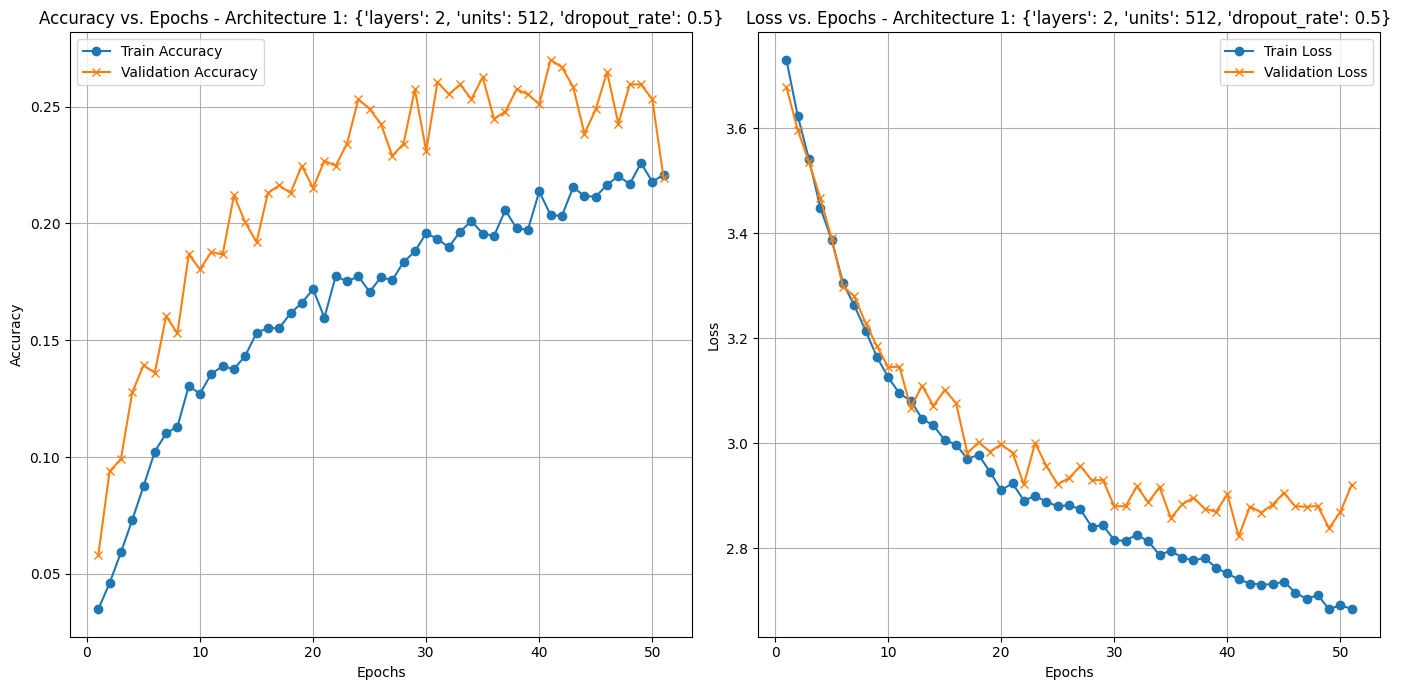

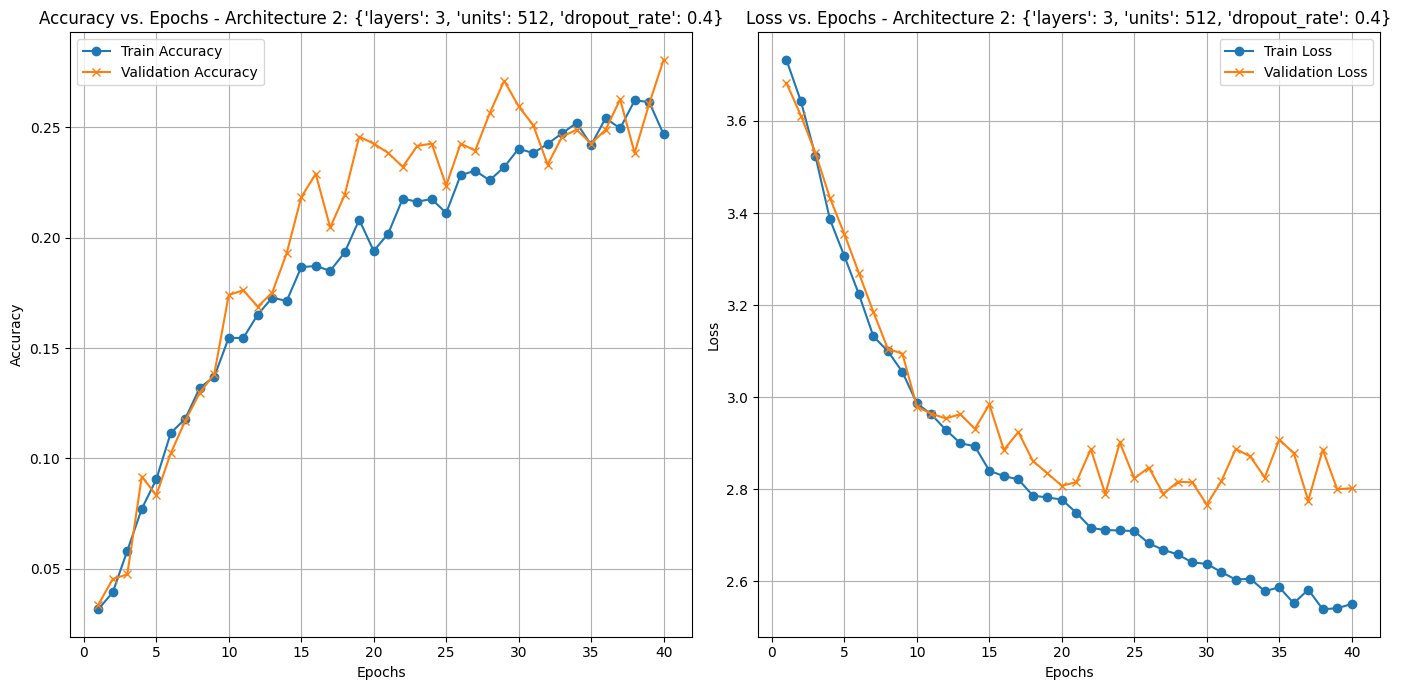

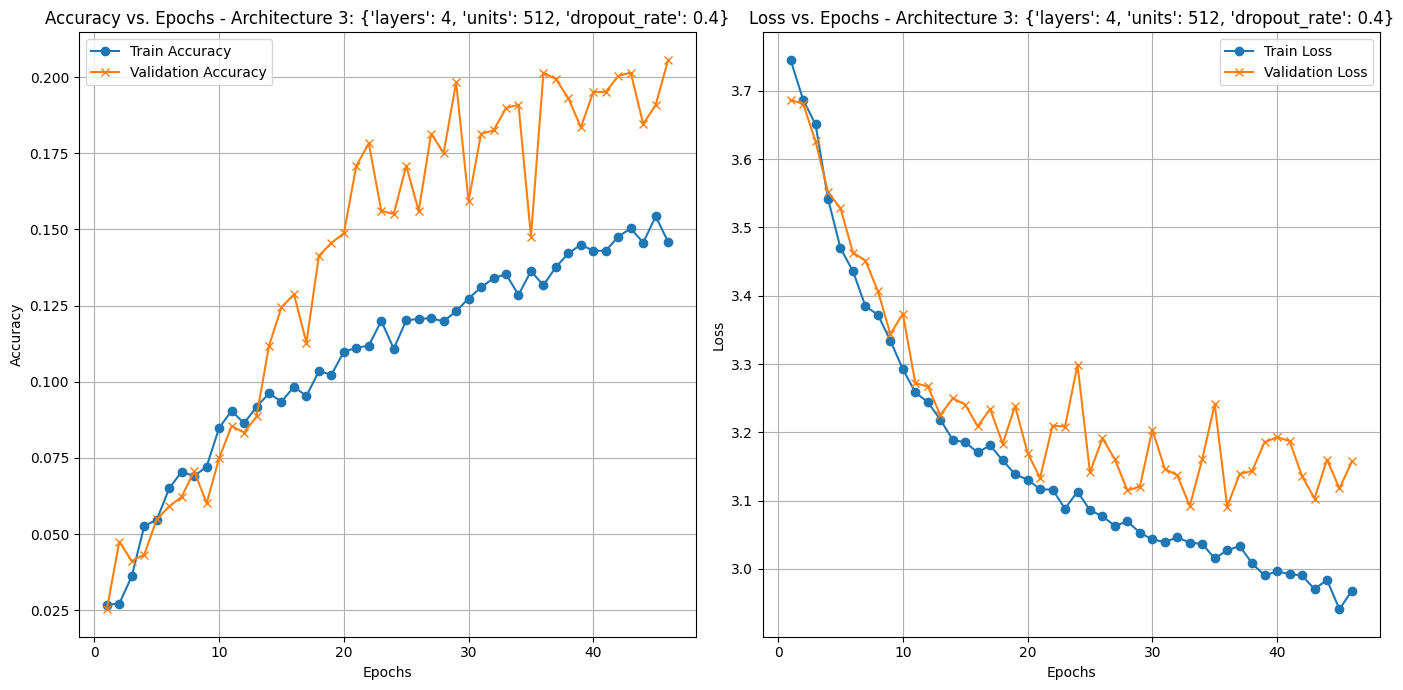

In [ ]:
for i, result in enumerate(test_results):
    history = result['history']
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    architecture = result['architecture']

    # Plotting accuracy and loss for all architectures
    plt.figure(figsize=(14, 7))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Train Accuracy', marker='o')
    plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy', marker='x')
    plt.title(f"Accuracy vs. Epochs - Architecture {i + 1}: {architecture}")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(train_loss) + 1), train_loss, label='Train Loss', marker='o')
    plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss', marker='x')
    plt.title(f"Loss vs. Epochs - Architecture {i + 1}: {architecture}")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

In [11]:
# Combine and compare cross-validation and test results
print("\nComparison of CV and Test Performance:")
for i, (cv_result, test_result) in enumerate(zip(cv_results, test_results)):
    print(f"Model {i + 1} - Architecture: {cv_result['architecture']}")
    print(f"  CV Accuracy: {cv_result['accuracy']:.4f}, Test Accuracy: {test_result['accuracy']:.4f}")
    print(f"  CV Precision: {cv_result['precision']:.4f}, Test Precision: {test_result['precision']:.4f}")
    print(f"  CV Recall: {cv_result['recall']:.4f}, Test Recall: {test_result['recall']:.4f}")
    print(f"  CV F1 Score: {cv_result['f1_score']:.4f}, Test F1 Score: {test_result['f1_score']:.4f}")


Comparison of CV and Test Performance:
Model 1 - Architecture: {'layers': 2, 'units': 512, 'dropout_rate': 0.5}
  CV Accuracy: 0.3865, Test Accuracy: 0.2700
  CV Precision: 0.3861, Test Precision: 0.3327
  CV Recall: 0.3865, Test Recall: 0.2700
  CV F1 Score: 0.3571, Test F1 Score: 0.2846
Model 2 - Architecture: {'layers': 3, 'units': 512, 'dropout_rate': 0.4}
  CV Accuracy: 0.3862, Test Accuracy: 0.2595
  CV Precision: 0.4193, Test Precision: 0.3311
  CV Recall: 0.3862, Test Recall: 0.2595
  CV F1 Score: 0.3748, Test F1 Score: 0.2730
Model 3 - Architecture: {'layers': 4, 'units': 512, 'dropout_rate': 0.4}
  CV Accuracy: 0.1305, Test Accuracy: 0.2015
  CV Precision: 0.1442, Test Precision: 0.2226
  CV Recall: 0.1305, Test Recall: 0.2015
  CV F1 Score: 0.1063, Test F1 Score: 0.1799


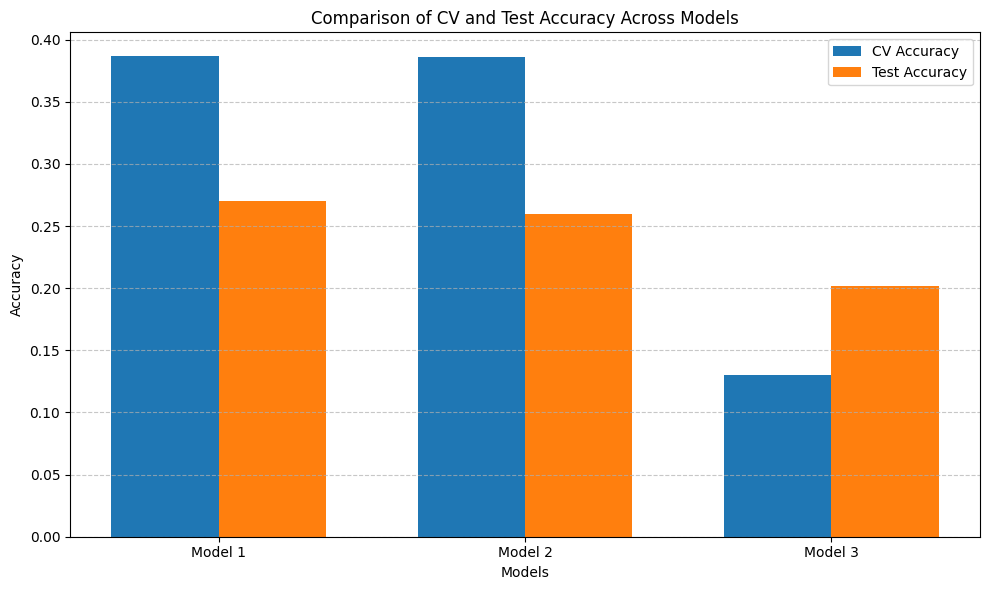

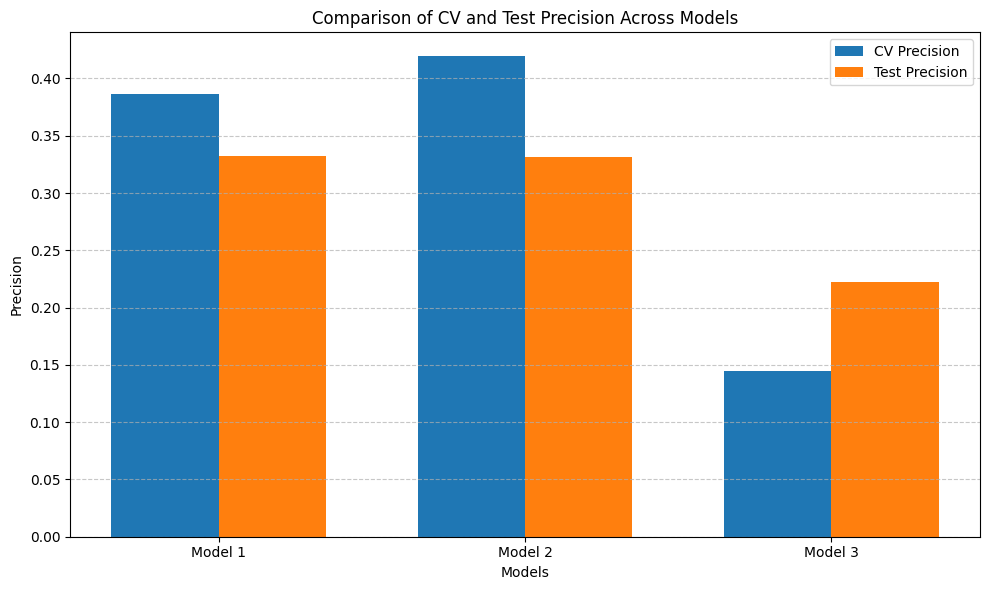

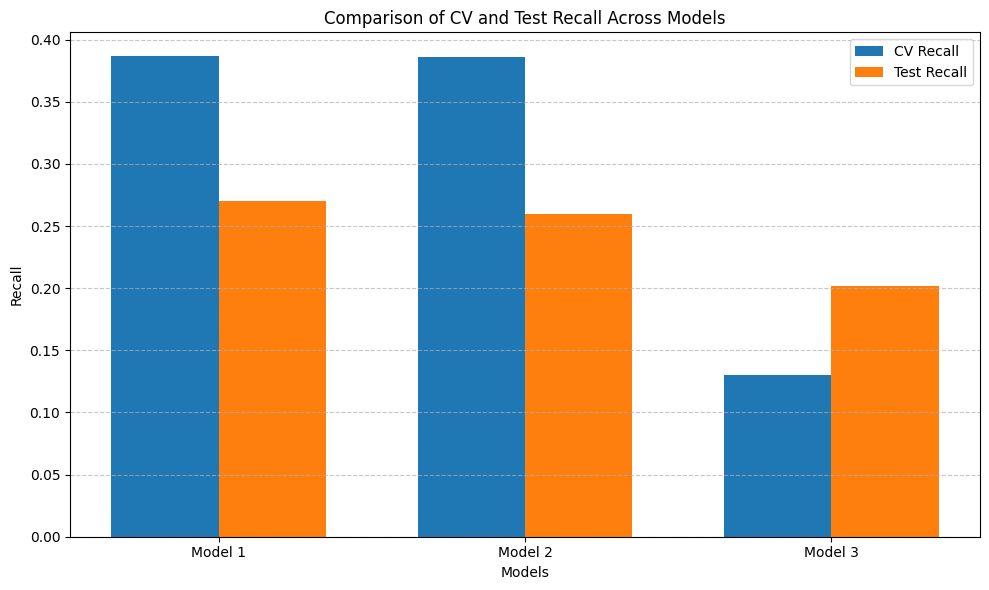

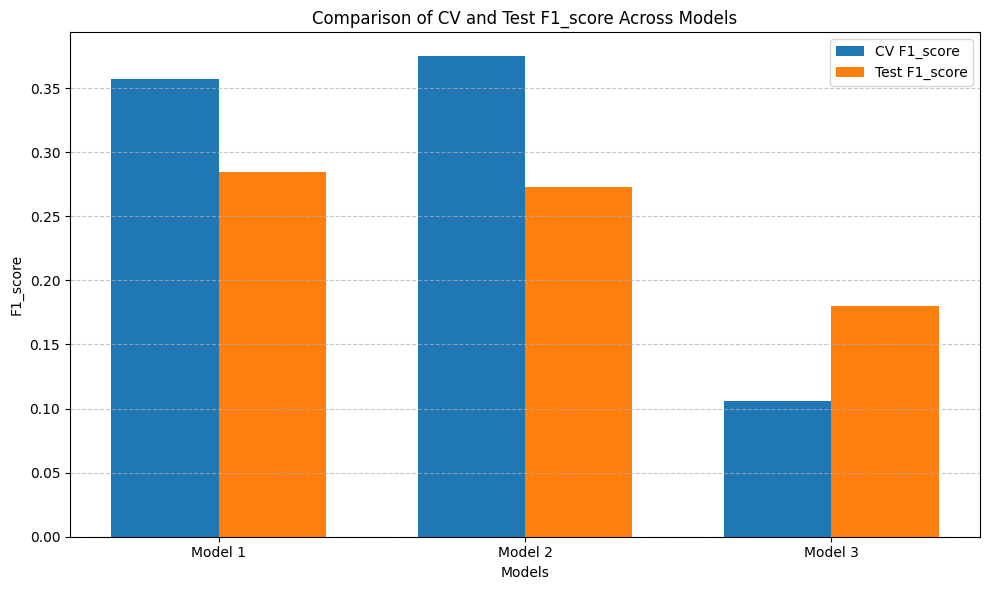

In [ ]:
metrics = ['accuracy', 'precision', 'recall', 'f1_score']
x_labels = [f"Model {i + 1}" for i in range(len(cv_results))]

# Prepare data for each metric
cv_data = {metric: [result[metric] for result in cv_results] for metric in metrics}
test_data = {metric: [result[metric] for result in test_results] for metric in metrics}

# Create bar plots for each metric
for metric in metrics:
    plt.figure(figsize=(10, 6))
    x = np.arange(len(x_labels))  # X-axis positions
    width = 0.35 

    # Plot bars for CV and Test data
    plt.bar(x - width/2, cv_data[metric], width, label=f'CV {metric.capitalize()}')
    plt.bar(x + width/2, test_data[metric], width, label=f'Test {metric.capitalize()}')

    plt.xlabel("Models")
    plt.ylabel(metric.capitalize())
    plt.title(f"Comparison of CV and Test {metric.capitalize()} Across Models")
    plt.xticks(x, x_labels)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

In [ ]:
# Performance metrics for all architectures
print("\nPerformance Metrics for All Architectures:")
for i, result in enumerate(test_results):
    print(f"Model {i + 1} - Architecture: {result['architecture']}")
    print(f"  Accuracy: {result['accuracy']:.4f}")
    print(f"  Precision: {result['precision']:.4f}")
    print(f"  Recall: {result['recall']:.4f}")
    print(f"  F1 Score: {result['f1_score']:.4f}")
    print(f"  Sensitivity: {result['sensitivity']:.4f}")


Performance Metrics for All Architectures:
Model 1 - Architecture: {'layers': 2, 'units': 512, 'dropout_rate': 0.5}
  Accuracy: 0.2700
  Precision: 0.3327
  Recall: 0.2700
  F1 Score: 0.2846
  Sensitivity: 0.2700
Model 2 - Architecture: {'layers': 3, 'units': 512, 'dropout_rate': 0.4}
  Accuracy: 0.2595
  Precision: 0.3311
  Recall: 0.2595
  F1 Score: 0.2730
  Sensitivity: 0.2595
Model 3 - Architecture: {'layers': 4, 'units': 512, 'dropout_rate': 0.4}
  Accuracy: 0.2015
  Precision: 0.2226
  Recall: 0.2015
  F1 Score: 0.1799
  Sensitivity: 0.2015
